In [37]:
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os 

load_dotenv()

True

In [38]:
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_PROJECT'] = "multi-agent-project"
os.environ['LANGSMITH_TRACING_V2'] = os.getenv('LANGSMITH_TRACING_V2')

llm = AzureChatOpenAI(
    api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT')
)

llm.invoke("hi")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protect

In [39]:
def add(a: float, b: float) -> float:
    """Add two numbers"""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers"""
    return a * b

tavily = TavilySearchResults()

def web_search(query: str):
    """Web search"""
    result = llm.bind_tools([tavily]).invoke(query)
    return result

In [40]:
from langgraph.prebuilt import create_react_agent

math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert perform all arithmetic operations. Only use one tool at a time"
)

research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher perform all research related activities. Do not do math"
)

In [41]:
from langgraph_supervisor import create_supervisor

prompt = """ You are a team supervisor managing a research expert and math expert.
For current events, use research_expert.
For math problems, use math_expert.
"""

workflow = create_supervisor(
    agents=[math_agent, research_agent],
    model=llm,
    prompt=prompt,
    output_mode="full_history"
    # clear_output="last_message"
)

app = workflow.compile()

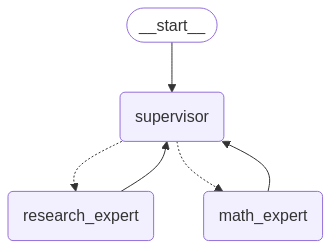

In [42]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [43]:
result = app.invoke({"messages": ("user", "what's the total population of China and japan in 2000? and multiply it by 2")})

In [44]:
result

{'messages': [HumanMessage(content="what's the total population of China and japan in 2000? and multiply it by 2", additional_kwargs={}, response_metadata={}, id='87f01a1d-d441-42ad-b802-73a9dd74092a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vq4pcXmtcehwiIHXLbHJN0PA', 'function': {'arguments': '{}', 'name': 'transfer_to_research_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 109, 'total_tokens': 123, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish

In [45]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

what's the total population of China and japan in 2000? and multiply it by 2
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_expert (call_vq4pcXmtcehwiIHXLbHJN0PA)
 Call ID: call_vq4pcXmtcehwiIHXLbHJN0PA
  Args:
================================= Tool Message =================================
Name: transfer_to_research_expert

Successfully transferred to research_expert
================================== Ai Message ==================================
Name: research_expert
Tool Calls:
  web_search (call_HILQFPvVU31oamWo0GmwQRAH)
 Call ID: call_HILQFPvVU31oamWo0GmwQRAH
  Args:
    query: total population of China in 2000
  web_search (call_A0Vbb9tKxAdeOXrjRlfQzJ2U)
 Call ID: call_A0Vbb9tKxAdeOXrjRlfQzJ2U
  Args:
    query: total population of Japan in 2000
================================= Tool Message =======================

# Hierarchical Agents

In [46]:
from typing import Literal

def get_precipitation(location: Literal["sf", "nyc"]):
    """Get precipiration forecast for location"""
    if location == "sf":
        return "will be raining" 
    elif location == "nyc":
        return "will be sunny"
    else:
        raise ValueError()
    
def get_temperature(location: Literal["sf", "nyc"]):
    """Get temperature forcase for location"""
    if location == "sf":
        return "will be 30 degrees"
    elif location == "nyc":
        return "will be 80 degrees"
    else:
        raise ValueError()

In [48]:
weather_team = [
    create_react_agent(
        model=llm,
        tools=[get_precipitation],
        name="percipitation_expert",
        prompt="You are a percipitation expert. Only work on percipitaiton forecast"
    ),
    create_react_agent(
        model=llm,
        tools=[get_temperature],
        name="temperature_expert",
        prompt="You are a temperature expert. Only work on temperature forecast."
    )
]

In [47]:
math_team = [
    create_react_agent(
        model=llm,
        tools=[add],
        name="additional_expert",
        prompt="You are a additional expert. Only work on addition, DO NOT attempt to solve \
            the full problem if it requires other expertise."
    ),
    create_react_agent(
        model=llm,
        tools=[multiply],
        name="multiplication_expert",
        prompt="You are a multiplication expert. Only work on multiplication, DO NOT attempt \
            to solve the full problem if it requires other expertise."
    )
]

In [49]:
math_supervisor = create_supervisor(
    agents=math_team,
    model=llm,
    prompt="You are a team supervisor, tasked with managing a multiplication expert and an addition expert.",
    supervisor_name="math_supervisor",
).compile(name = "math_team")

weather_supervisor = create_supervisor(
    agents=weather_team,
    model=llm,
    prompt=(
        """ You are a weather forecast expert, tasked with managing temperatre forecast expert and a \
            percipitation forecast  expert.
            Don't ask for clarifications.
            Always respond to the user with the weather forecast according to your team experts.
            DO NOT make up answer -- ask experts!
            You MUST ALWAYS respond to the user with the final answer, do not respond with empty text.
        """
    ),
    supervisor_name="weather_supervisor",
).compile(name="weather_team")

hieararchical_supervisor = create_supervisor(
    agents=[math_supervisor, weather_supervisor],
    supervisor_name="top_level_supervisor",
    model=llm,
    prompt="You are a team supervisor, tasked with managing a weather expert and a math expert. \
        Once you have the answer to the user's question finish"
).compile()

In [52]:
message = hieararchical_supervisor.invoke({"messages": [("user", "What's the weather in nyc?")]})

In [53]:
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

What's the weather in nyc?
================================== Ai Message ==================================
Name: top_level_supervisor
Tool Calls:
  transfer_to_weather_team (call_ZOvIblWIaLZaaQneWiB16kFG)
 Call ID: call_ZOvIblWIaLZaaQneWiB16kFG
  Args:
================================= Tool Message =================================
Name: transfer_to_weather_team

Successfully transferred to weather_team
================================== Ai Message ==================================
Name: weather_supervisor

The weather in NYC will be sunny with a temperature of 80 degrees.
================================== Ai Message ==================================
Name: weather_team

Transferring back to top_level_supervisor
Tool Calls:
  transfer_back_to_top_level_supervisor (4c9b4300-7b28-4a61-8bd6-c376cae33022)
 Call ID: 4c9b4300-7b28-4a61-8bd6-c376cae33022
  Args:
================================= Tool Message 